# Preparation

In [139]:
# Declare the normal class and the dimension of the latent space
# For QSVDD: num_params_conv <- 15, cost_func <- 'svdd', steps = 500
# For QAE: num_params_conv <- 8, cost_func <- 'qae', steps = 2000
# For QAE test: cost_func <- qae_test, num_params_conv <- 8, steps = 2000

# dataset <- 'mnist', 'fmnist', 'kmnist'
# ntrain <- number of class want to train
# latent_dim <- 3, 6, 9, 12, 15

dataset = 'kmnist'
ntrain = 0 ; latent_dim = 12
num_params_conv = 8 
cost_func = 'qae'
steps = 2000
learning_rate = 0.001
batch_size = 16


In [140]:
pwd

'c:\\Users\\user1\\Quantum\\QSVDD_real'

In [141]:
from pathlib import Path
import numpy as np

# Let us define some paths first
input_path = Path("./kuzushiji_data")

# Path to training images and corresponding labels provided as numpy arrays
kmnist_train_images_path = input_path/"kmnist-train-imgs.npz"
kmnist_train_labels_path = input_path/"kmnist-train-labels.npz"

# Path to the test images and corresponding labels
kmnist_test_images_path = input_path/"kmnist-test-imgs.npz"
kmnist_test_labels_path = input_path/"kmnist-test-labels.npz"

# Load the training data from the corresponding npz files
kmnist_train_images = np.load(kmnist_train_images_path)['arr_0']
kmnist_train_labels = np.load(kmnist_train_labels_path)['arr_0']

# Load the test data from the corresponding npz files
kmnist_test_images = np.load(kmnist_test_images_path)['arr_0']
kmnist_test_labels = np.load(kmnist_test_labels_path)['arr_0']

print(f"Number of training samples: {len(kmnist_train_images)} where each sample is of size: {kmnist_train_images.shape[1:]}")
print(f"Number of test samples: {len(kmnist_test_images)} where each sample is of size: {kmnist_test_images.shape[1:]}")


Number of training samples: 60000 where each sample is of size: (28, 28)
Number of test samples: 10000 where each sample is of size: (28, 28)


In [142]:
# Import libraries

from pennylane import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pennylane as qml

In [143]:
import sys
sys.version

'3.9.16 (main, May 17 2023, 17:49:16) [MSC v.1916 64 bit (AMD64)]'

In [144]:
import tensorflow as tf
import numpy as np
import pennylane as qml

def data(ntrain, latent_dim, dataset):
    if dataset == 'mnist':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    elif dataset == 'fmnist':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    elif dataset == 'kmnist':        
        x_train = kmnist_train_images
        x_test = kmnist_test_images
        y_train = kmnist_train_labels
        y_test = kmnist_test_labels
        
    # 데이터 정규화 및 필터링
    x_train, x_test = x_train[..., np.newaxis] / 255.0, x_test[..., np.newaxis] / 255.0
    
    
    # # 이미지 크기 조정
    # X_train = tf.image.resize(X_train[:], (256, 1)).numpy()
    # X_test = tf.image.resize(X_test[:], (256, 1)).numpy()
    # X_train, X_test = tf.squeeze(X_train).numpy(), tf.squeeze(X_test).numpy()

    x_train = tf.image.resize(x_train[:], (256, 1)).numpy()
    x_test = tf.image.resize(x_test[:], (256, 1)).numpy()
    x_train, x_test = tf.squeeze(x_train).numpy(), tf.squeeze(x_test).numpy()
    
    zero_train = np.where(np.all(x_train == 0, axis=1))[0]
    zero_test = np.where(np.all(x_test == 0, axis=1))[0]

    mask_train = np.ones(len(x_train), dtype=bool)
    mask_train[zero_train] = False
    mask_test = np.ones(len(x_test), dtype=bool)
    mask_test[zero_test] = False

    x_train = x_train[mask_train]
    x_test = x_test[mask_test]
    y_train = y_train[mask_train]
    y_test = y_test[mask_test]
    
    x_train_filter = np.where(y_train == ntrain)
    x_test_filter = np.where(y_test == ntrain)

    # 필터링된 데이터
    X_train = x_train[x_train_filter]
    X_test = x_test[x_test_filter]
    Y_train = y_train[x_train_filter]
    Y_test = y_test[x_test_filter]



    center = qml.numpy.zeros(latent_dim, requires_grad=True)
    center_train = np.tile(center,(len(X_train),1))
    print('x_train:',x_train.shape)
    print('x_test:',x_test.shape)
    print('y_train:',y_train.shape)
    print('y_test:',y_test.shape)
    print('X_train:',X_train.shape)
    print('X_test:',X_test.shape)
    print('Y_train:',Y_train.shape)
    print('Y_test:',Y_test.shape)
    return x_train, y_train, x_test, y_test, X_train, X_test, Y_train, Y_test, center_train


In [145]:
x_train, y_train, x_test, y_test, X_train, X_test, Y_train, Y_test, center_train = data(ntrain, latent_dim, dataset)

x_train: (58355, 256)
x_test: (9763, 256)
y_train: (58355,)
y_test: (9763,)
X_train: (5800, 256)
X_test: (877, 256)
Y_train: (5800,)
Y_test: (877,)


In [146]:
# Data embedding

from pennylane.templates.embeddings import AmplitudeEmbedding

def data_embedding(X, embedding_type='Amplitude'):
    if embedding_type == 'Amplitude':
        AmplitudeEmbedding(X, wires=range(8), normalize=True)

In [147]:
# Unitary

def U_SU4(params, wires): # 15 params
    qml.U3(params[0], params[1], params[2], wires=wires[0])
    qml.U3(params[3], params[4], params[5], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[6], wires=wires[0])
    qml.RZ(params[7], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[8], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.U3(params[9], params[10], params[11], wires=wires[0])
    qml.U3(params[12], params[13], params[14], wires=wires[1])

from itertools import combinations
def U_QAE(params): # params: 14
    nqubits = 8
    ntrash = 6
    for i in range(nqubits):
        qml.RY(params[i], wires = i)
        
    for i,j in combinations(range(0, ntrash), 2): # CZ between trash qubits
        qml.CZ(wires = [i, j])
        
    for idx in range(ntrash): # CZ between trash and non-trash qubits
        for i in range(ntrash):
            for j in range(ntrash+i,nqubits,ntrash):
                qml.CZ(wires = [(idx+i)%(ntrash),j])       

def U_QAE_last(params):
    ntrash = 6
    for i in range(ntrash):
        qml.RY(params[i], wires = i)

In [148]:
# Convolution layer

def conv_layer_1(U, params):
    for i in range(0, 8, 2):
        U(params, wires=[i, i + 1])
    for i in range(1, 7, 2):
        U(params, wires=[i, i + 1])
    U(params, wires=[7,0])

def conv_layer_2(U, params):
    U(params, wires=[2,4])
    U(params, wires=[6,0])
    U(params, wires=[0,2])
    U(params, wires=[4,6])
    
def conv_layer_3(U, params):
    U(params, wires=[2,6])
    
def QCNN_structure_without_pooling(U, params, U_params): #75
    param1 = params[0:U_params]
    param2 = params[U_params: 2 * U_params]
    param3 = params[2 * U_params: 3 * U_params]
    param4 = params[3 * U_params: 4 * U_params]
    param5 = params[4 * U_params: 5 * U_params]

    conv_layer_1(U, param1)
    conv_layer_1(U, param2)
    conv_layer_2(U, param3)
    conv_layer_2(U, param4)
    conv_layer_3(U, param5)
    
def QSVDD_QAE(U, params, U_params):
    param1 = params[0:U_params]
    param2 = params[U_params: 2 * U_params]
    param3 = params[2 * U_params: 3 * U_params]
    param4 = params[3 * U_params: 4 * U_params]
    param5 = params[4 * U_params: 5 * U_params]    
    param6 = params[5 * U_params: 6 * U_params]
    param7 = params[6 * U_params: 7 * U_params]
    param8 = params[7 * U_params: 8 * U_params]
    param9 = params[8 * U_params: 9 * U_params]
    param10 = params[9 * U_params: 78]
    
    U_QAE(param1)
    U_QAE(param2)
    U_QAE(param3)
    U_QAE(param4)
    U_QAE(param5)
    U_QAE(param6)
    U_QAE(param7)
    U_QAE(param8)
    U_QAE(param9)
    U_QAE_last(param10)


# Training

In [149]:

def qae_loss(Y, predictions):
    loss = 0
    for l, p in zip(Y, predictions):
        loss = loss + (-np.sum(p))
    loss = loss / len(Y)
    return loss

def svdd_loss(Y, predictions):
    loss = 0
    for l, p in zip(Y, predictions):
        loss = loss + np.sum(np.array(p-l)**2)
    loss = loss / len(Y)
    return loss

    # Cost
def cost(params, X, Y, U_params, latent_dim, cost_fn):
    predictions = np.array([QCNN(x, params, U_params, latent_dim, cost_fn) for x in X])
    if cost_fn == 'qae':
        loss_value = qae_loss(Y, predictions)

    elif cost_fn == 'svdd':
        #print(predictions)
        loss_value = np.square(np.subtract(predictions, Y)).mean()
        # return qml.math.toarray(loss_value)
    return loss_value
def circuit_training(X_train, Y_train, U_params, cost_fn, latent_dim):
    # if (circuit == 'QCNN')&(U != 'U_SU4_no_pooling'):
    #     total_params = U_params * 3 + 2 * 3
    # elif (circuit == 'QCNN')&(U == 'U_SU4_no_pooling'):
    #     total_params = U_params * 5
    if cost_fn == 'qae':
        params = np.random.randn(78, requires_grad = True)

    elif cost_fn == 'svdd':    
        params = np.random.randn(U_params * 5, requires_grad = True)
    # init_center = np.mean([QCNN_circuit.QCNN(x, params, U, U_params, embedding_type, latent_dim, cost_fn, measure_axis=measure_axis) for x in X_train])
    # Y_train = np.tile(init_center, (len(X_train), 1))
    
    # Optimizer method
    opt = qml.AdamOptimizer(stepsize=learning_rate)    
    # opt = qml.NesterovMomentumOptimizer(stepsize = learning_rate, momentum=0.9)
    param_history= [params]
    loss_history = []

    # Loss function


    # Optimization
    for it in range(steps):

        batch_index = np.random.randint(0, len(X_train), (batch_size,))
        X_batch = np.array([X_train[i] for i in batch_index])
        Y_batch = np.array([Y_train[i] for i in batch_index])

        params, cost_new = opt.step_and_cost(lambda v: cost(v, X_batch, Y_batch, U_params, latent_dim, cost_fn), params)
        param_history.append(params)
        loss_history.append(cost_new)

        # if it % 5 == 0:
        #     print("iteration: ", it, " cost: ", cost_new)

        print("iteration: ", it, " cost: ", cost_new)


    return loss_history, params, param_history


In [150]:
# QCNN
from pennylane import numpy as np

dev = qml.device('default.qubit', wires = 8)
@qml.qnode(dev, interface = 'autograd', diff_method = 'backprop')
def QCNN(X, params, U_params, latent_dim, cost_fn):
    # Data embedding
    data_embedding(X, embedding_type='Amplitude')
    
    if cost_fn == 'qae':
        QSVDD_QAE(U_QAE, params, U_params)
        result = [qml.expval(qml.PauliZ(i)) for i in (0,1,2,3,4,5)]
    elif cost_fn == 'qae_test':
        QSVDD_QAE(U_QAE, params, U_params)
        if latent_dim == 9:
            result =[qml.expval(qml.PauliX(6)),qml.expval(qml.PauliY(6)),qml.expval(qml.PauliZ(6)), 
                        qml.expval(qml.PauliX(7)),qml.expval(qml.PauliY(7)),qml.expval(qml.PauliZ(7)),
                        qml.expval(qml.PauliX(6) @ qml.PauliX(7)), qml.expval(qml.PauliY(6) @ qml.PauliY(7)), 
                        qml.expval(qml.PauliZ(6) @ qml.PauliZ(7))]
        elif latent_dim == 12:
            result = [qml.expval(qml.PauliX(6)),qml.expval(qml.PauliY(6)),qml.expval(qml.PauliZ(6)), 
                        qml.expval(qml.PauliX(7)),qml.expval(qml.PauliY(7)),qml.expval(qml.PauliZ(7)),
                        qml.expval(qml.PauliX(6) @ qml.PauliX(7)), qml.expval(qml.PauliY(6) @ qml.PauliY(7)), 
                        qml.expval(qml.PauliZ(6) @ qml.PauliZ(7)),
                        qml.expval(qml.PauliX(6) @ qml.PauliY(7)), qml.expval(qml.PauliY(6) @ qml.PauliZ(7)), 
                        qml.expval(qml.PauliZ(6) @ qml.PauliX(7))]
        elif latent_dim == 15:
            result = [qml.expval(qml.PauliX(6)),qml.expval(qml.PauliY(6)),qml.expval(qml.PauliZ(6)), 
                        qml.expval(qml.PauliX(7)),qml.expval(qml.PauliY(7)),qml.expval(qml.PauliZ(7)),
                        qml.expval(qml.PauliX(6) @ qml.PauliX(7)), qml.expval(qml.PauliY(6) @ qml.PauliY(7)), 
                        qml.expval(qml.PauliZ(6) @ qml.PauliZ(7)),
                        qml.expval(qml.PauliX(6) @ qml.PauliY(7)), qml.expval(qml.PauliY(6) @ qml.PauliZ(7)), 
                        qml.expval(qml.PauliZ(6) @ qml.PauliX(7)),
                        qml.expval(qml.PauliX(6) @ qml.PauliZ(7)), qml.expval(qml.PauliY(6) @ qml.PauliX(7)), 
                        qml.expval(qml.PauliZ(6) @ qml.PauliY(7))]

    elif cost_fn == 'svdd':
        QCNN_structure_without_pooling(U_SU4, params, U_params)
        if latent_dim == 1:
            result = qml.expval(qml.PauliZ(6))
        elif latent_dim == 3:
            result = qml.expval(qml.PauliX(2)),qml.expval(qml.PauliY(2)),qml.expval(qml.PauliZ(2))
        elif latent_dim == 6:
            result = [qml.expval(qml.PauliX(2)),qml.expval(qml.PauliY(2)),qml.expval(qml.PauliZ(2)), 
                        qml.expval(qml.PauliX(6)),qml.expval(qml.PauliY(6)),qml.expval(qml.PauliZ(6))]
        elif latent_dim == 9:
            result = [qml.expval(qml.PauliX(2)),qml.expval(qml.PauliY(2)),qml.expval(qml.PauliZ(2)), 
                        qml.expval(qml.PauliX(6)),qml.expval(qml.PauliY(6)),qml.expval(qml.PauliZ(6)),
                        qml.expval(qml.PauliX(2) @ qml.PauliX(6)), qml.expval(qml.PauliY(2) @ qml.PauliY(6)), 
                        qml.expval(qml.PauliZ(2) @ qml.PauliZ(6))]
        elif latent_dim == 12:
            result = [qml.expval(qml.PauliX(2)),qml.expval(qml.PauliY(2)),qml.expval(qml.PauliZ(2)), 
                        qml.expval(qml.PauliX(6)),qml.expval(qml.PauliY(6)),qml.expval(qml.PauliZ(6)),
                        qml.expval(qml.PauliX(2) @ qml.PauliX(6)), qml.expval(qml.PauliY(2) @ qml.PauliY(6)), 
                        qml.expval(qml.PauliZ(2) @ qml.PauliZ(6)),
                        qml.expval(qml.PauliX(2) @ qml.PauliY(6)), qml.expval(qml.PauliY(2) @ qml.PauliZ(6)), 
                        qml.expval(qml.PauliZ(2) @ qml.PauliX(6))]
        elif latent_dim == 15:
            result = [qml.expval(qml.PauliX(2)),qml.expval(qml.PauliY(2)),qml.expval(qml.PauliZ(2)), 
                        qml.expval(qml.PauliX(6)),qml.expval(qml.PauliY(6)),qml.expval(qml.PauliZ(6)),
                        qml.expval(qml.PauliX(2) @ qml.PauliX(6)), qml.expval(qml.PauliY(2) @ qml.PauliY(6)), 
                        qml.expval(qml.PauliZ(2) @ qml.PauliZ(6)),
                        qml.expval(qml.PauliX(2) @ qml.PauliY(6)), qml.expval(qml.PauliY(2) @ qml.PauliZ(6)), 
                        qml.expval(qml.PauliZ(2) @ qml.PauliX(6)),
                        qml.expval(qml.PauliX(2) @ qml.PauliZ(6)), qml.expval(qml.PauliY(2) @ qml.PauliX(6)), 
                        qml.expval(qml.PauliZ(2) @ qml.PauliY(6))]
            
    return result

train_Xdata = X_train
train_Ydata = center_train


loss_history, est_params, param_history = circuit_training(X_train=train_Xdata,
                                            Y_train=train_Ydata,
                                            U_params=num_params_conv,
                                            latent_dim = latent_dim,
                                            cost_fn=cost_func)

iteration:  0  cost:  0.445207186118187
iteration:  1  cost:  0.4053356780838528
iteration:  2  cost:  0.4008098865670007
iteration:  3  cost:  0.3931930049734448
iteration:  4  cost:  0.36503348650067746
iteration:  5  cost:  0.46220818281403636
iteration:  6  cost:  0.3739153559596689
iteration:  7  cost:  0.35135334247121014
iteration:  8  cost:  0.4065914100278582
iteration:  9  cost:  0.27766143514752817
iteration:  10  cost:  0.3194923821183241
iteration:  11  cost:  0.41832460706874236
iteration:  12  cost:  0.4373878046756883
iteration:  13  cost:  0.38590226743640194
iteration:  14  cost:  0.3505936728532154
iteration:  15  cost:  0.2578340952836686
iteration:  16  cost:  0.2732934441917136
iteration:  17  cost:  0.2864880242451006
iteration:  18  cost:  0.39132112735739016
iteration:  19  cost:  0.32590071030963913
iteration:  20  cost:  0.2392330702284258
iteration:  21  cost:  0.2789454162317225
iteration:  22  cost:  0.33615655257374455
iteration:  23  cost:  0.38505078171

# Plots

Text(0.5, 1.0, 'Loss convergence')

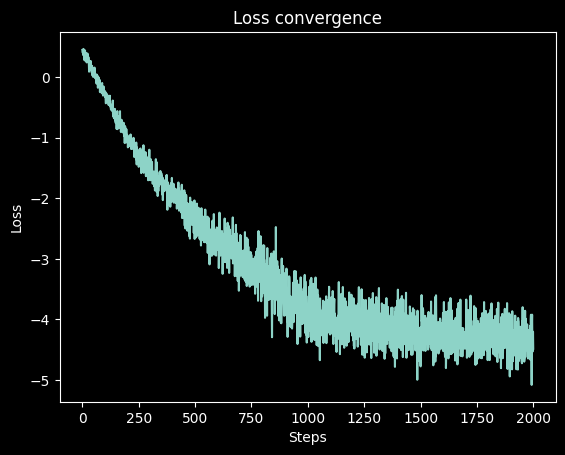

In [151]:
plt.plot(loss_history)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Loss convergence")

# plt.savefig('./img/OCC0/qsvdd/cost_qcnn.png')

In [152]:
# savetxt('./img/OCC0/qsvdd/param_list_qcnn',est_params.numpy(),delimiter=',')

Text(0.5, 1.0, 'Parameter convergence')

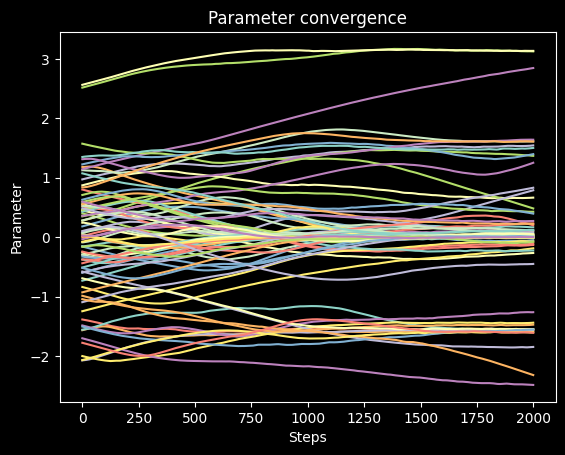

In [153]:
plt.plot(param_history)
plt.xlabel("Steps")
plt.ylabel("Parameter")
plt.title("Parameter convergence")
# plt.savefig('./img/OCC0/qsvdd/parameters_qcnn.png')

# Test

In [154]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

def radius(data, center):
    res = []
    # for j in range(len(data)):
    #     res.append(sum(abs(data - center)[j]**2))
    res.append(abs(data - center)**2)
    return res


In [155]:
import numpy as np
import random

# Remove this option for QSVDD: cost_func = 'qae_test'
cost_func = 'qae_test'
trained_params = est_params
y_true = []
y_pred = []

def test(ntrain, latent_dim):
    if cost_func == 'svdd':
        if latent_dim == 1:
            for i in range(10):
                if i == ntrain:
                    filter = np.where(y_test == ntrain)
                    test_data = x_test[filter]
                    pred = np.asarray([QCNN(x, trained_params, U_params = num_params_conv,
                                        latent_dim = latent_dim, cost_fn = cost_func) for x in test_data])
                    for j in range(len(pred)):
                        y_pred.append((pred**2)[j])
                        y_true.append(0)     
                else:
                    filter = np.where(y_test == i)
                    test_data = x_test[filter]
                    idx_test = random.sample(range(len(test_data)),100)
                    test_data = test_data[idx_test]
                    pred = np.asarray([QCNN(x, trained_params, U_params = num_params_conv,
                                        latent_dim = latent_dim, cost_fn = cost_func) for x in test_data])
                    for j in range(len(pred)):
                        y_pred.append((pred**2)[j])
                        y_true.append(1)
        else:
            for i in range(10):
                if i == ntrain:
                    filter = np.where(y_test == ntrain)
                    test_data = x_test[filter]
                    test_label = y_test[filter]
                    pred = np.asarray([QCNN(x, trained_params, U_params = num_params_conv,
                                        latent_dim = latent_dim, cost_fn = cost_func) for x in test_data])
                    for j in range(len(pred)):
                        y_pred.append((pred**2).mean(axis=1)[j])
                        y_true.append(0)
                else:
                    filter = np.where(y_test == i)
                    test_data = x_test[filter]
                    idx_test = random.sample(range(len(test_data)),100)
                    test_data = test_data[idx_test]
                    pred = np.asarray([QCNN(x, trained_params, U_params = num_params_conv,
                                        latent_dim = latent_dim, cost_fn = cost_func) for x in test_data])
                    for j in range(len(pred)):
                        y_pred.append((pred**2).mean(axis=1)[j])
                        y_true.append(1)
                        
    if cost_func == 'qae_test':
        c = np.mean(np.asarray([QCNN(x, trained_params,U_params=num_params_conv, latent_dim = latent_dim,
                                                 cost_fn=cost_func) for x in X_train]),axis=0)
        if latent_dim == 1:
            for i in range(10):
                if i == ntrain:
                    filter = np.where(y_test == ntrain)
                    test_data = x_test[filter]
                    pred = np.asarray([QCNN(x, trained_params, U_params = num_params_conv,
                                        latent_dim = latent_dim, cost_fn = cost_func) for x in test_data])
                    for j in range(len(pred)):
                        y_pred.append(((pred-c)**2)[j])
                        y_true.append(0)     
                else:
                    filter = np.where(y_test == i)
                    test_data = x_test[filter]
                    idx_test = random.sample(range(len(test_data)),100)
                    test_data = test_data[idx_test]
                    pred = np.asarray([QCNN(x, trained_params, U_params = num_params_conv,
                                        latent_dim = latent_dim, cost_fn = cost_func) for x in test_data])
                    for j in range(len(pred)):
                        y_pred.append(((pred-c)**2)[j])
                        y_true.append(1)
        else:
            for i in range(10):
                if i == ntrain:
                    filter = np.where(y_test == ntrain)
                    test_data = x_test[filter]
                    test_label = y_test[filter]
                    pred = np.asarray([QCNN(x, trained_params, U_params = num_params_conv,
                                        latent_dim = latent_dim, cost_fn = cost_func) for x in test_data])
                    for j in range(len(pred)):
                        y_pred.append(((pred-c)**2).mean(axis=1)[j])
                        y_true.append(0)
                else:
                    filter = np.where(y_test == i)
                    test_data = x_test[filter]
                    idx_test = random.sample(range(len(test_data)),100)
                    test_data = test_data[idx_test]
                    pred = np.asarray([QCNN(x, trained_params, U_params = num_params_conv,
                                        latent_dim = latent_dim, cost_fn = cost_func) for x in test_data])
                    for j in range(len(pred)):
                        y_pred.append(((pred-c)**2).mean(axis=1)[j])
                        y_true.append(1)
                        
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc = roc_auc_score(y_true,y_pred)
    return auc, y_pred, y_true, fpr, tpr


In [156]:
auc, y_pred, y_true, fpr, tpr = test(ntrain, latent_dim)

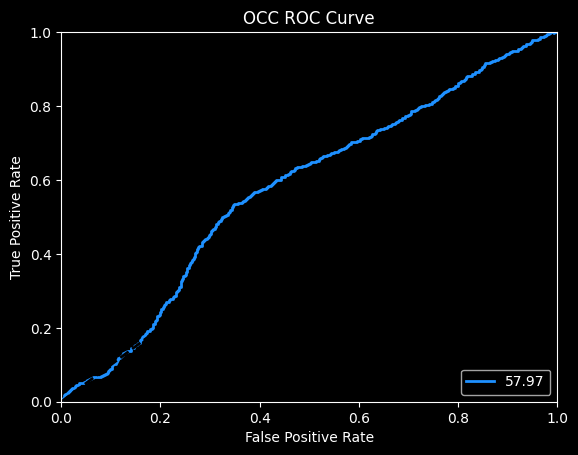

In [157]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='dodgerblue',lw=lw,label="{:.2f}".format(auc * 100))
plt.plot([0, 1], [0, 1], color="black", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("OCC ROC Curve")
plt.legend(loc="lower right")
# plt.savefig('./img/OCC0/qsvdd/OCC0_ROC_all.png')
plt.show()

In [158]:
print("{:.2f}".format(auc * 100))

57.97


In [159]:
import os

def save_auc_to_file(auc, ntrain, file_name):
    auc = "{:.2f}".format(auc * 100)
    directory = os.path.dirname(file_name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # 파일 이름에 ntrain 변수를 포함
    formatted_file_name = file_name.format(ntrain=ntrain)

    if not os.path.exists(formatted_file_name):
        with open(formatted_file_name, 'w') as f:
            pass
    with open(formatted_file_name, 'a') as f:
        f.write(str(auc) + "\n")

# Example usage
save_auc_to_file(auc, ntrain, "./result/auc_results_{ntrain}.txt")
